#Objective:
Extract data portions to improve the accuracy of a CNN model for human activity recognition using sensor data.

#Assumption/Challenges:
Presence of potential outliers in the dataset.

#Method: Isolation Forest



Isolation Forest is a distance-based algorithm.

Conceptual Foundation:
Isolation Forest, often abbreviated as iForest, stands apart from many conventional outlier detection methods. Whereas many traditional methods primarily focus on the local properties of data (e.g., clustering or density-based methods), iForest uses a unique partitioning approach. It isolates anomalies instead of profiling normal data points, making it particularly efficient [1]. The primary principle behind iForest is that anomalies are 'few and different'. This means that anomalous data points can be easily 'isolated' from the rest of the dataset.

Although it's generally less sensitive to feature scaling than other algorithms (like k-means clustering or SVM), it might still be beneficial to scale the features. Both scaled and unscaled versions of the data were used for the CNN model and there was no change in the output.

However, just the scaled version is shown in this notebook.

#Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


import sys
sys.path.append('/content/drive/My Drive/Fortifyedge/scripts')

from helper_functions import create_windows, create_model, train_model, plot_history, eval_model, plot_cm, perf_metric, transform_data, optimized_train_eval_model,pred,perf,plot_roc_multimodel,plot_cms

In [2]:
# Load your sensor data into a DataFrame
data_PATH = '/content/drive/MyDrive/Fortifyedge/data/'
data = pd.read_csv(data_PATH + 'clean.csv')

data['act'] = pd.Categorical(data.act)
data['id'] = pd.Categorical(data.id)

ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]

# Define the mapping of numeric values to their corresponding string labels
act_mapping = {float(i): label for i, label in enumerate(ACT_LABELS)}

# Replace the numeric values with string labels
data['act'] = data['act'].replace(act_mapping)

# Specify the columns that contain sensor readings (exclude 'act' and 'id' columns)
sensor_columns = ['rotationRate.x', 'rotationRate.y', 'rotationRate.z',
                   'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

Visualizing the pairwise relationships of the sensor readings in the data.

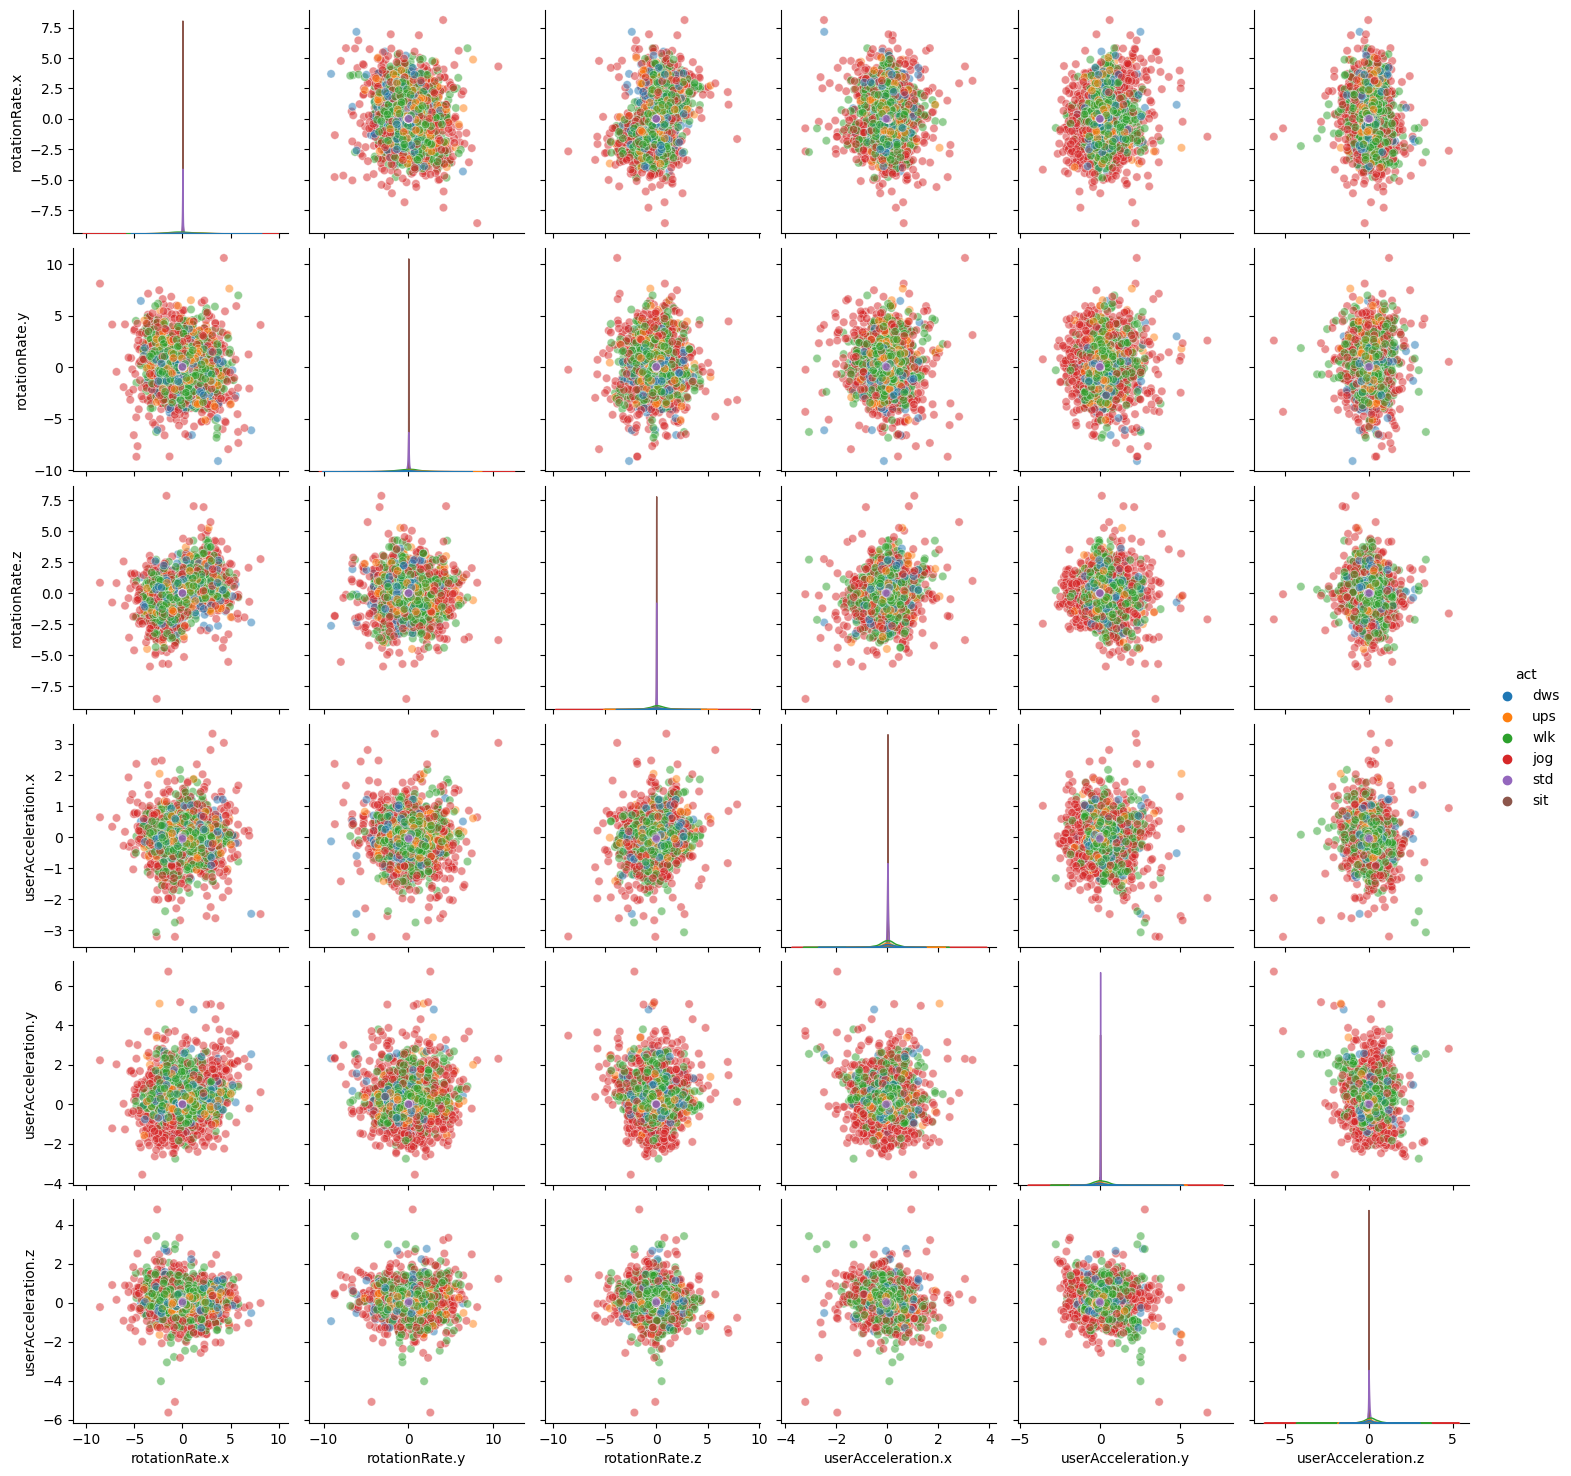

In [6]:
# Sample a subset of your data for visualization
sample_df = data.sample(n=10000)

# Create a pair plot
sns.pairplot(sample_df, vars=sensor_columns, hue='act', plot_kws={'alpha': 0.5})
plt.show()


Insights:



*   Density of Data Points: Most scatter plots show a dense clustering of points around the center, suggesting that the majority of the data values for these sensor readings are relatively close to each other.
*   Distinguishing Features: Some plots show more separation between activities than others. For instance, the scatter plot of userAcceleration.z against other features seems to show some differentiation between activities.

*   Outliers: Some plots have sparse data points spread out from the central cluster. These can be considered as outliers or rare observations for certain activities. Identifying and handling outliers can sometimes improve model performance.
*   Some scatter plots look quite similar to each other, suggesting that there might be correlation or redundancy between some sensor readings.





The below snippet is to find the best contamination parameter for iForest method. Time-based cross-validation has been applied to find which value fits the model best. I have been restricted the range from 0.1 to 0.11 with the hope to not loose to much valuable information.

In [ ]:
# Extract the sensor data
X = data[sensor_columns]

# # Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform
X_scaled = scaler.fit_transform(X)

# Define a range of contamination values to test
contamination_values = np.arange(0.01, 0.11, 0.01)

# Create an empty list to store cross-validation scores
cv_scores = []

# Initialize time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Loop through each contamination value and evaluate the model with time-based cross-validation
for contamination in contamination_values:
    scores = []
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]

        clf = IsolationForest(contamination=contamination, random_state=42)
        clf.fit(X_train)
        outlier_predictions = clf.predict(X_test)

        scores.append(np.mean(outlier_predictions == -1))

    cv_scores.append(np.mean(scores))

# Find the best contamination value with the highest cross-validation score
best_contamination = contamination_values[np.argmax(cv_scores)]
print("Best Contamination Value:", best_contamination)




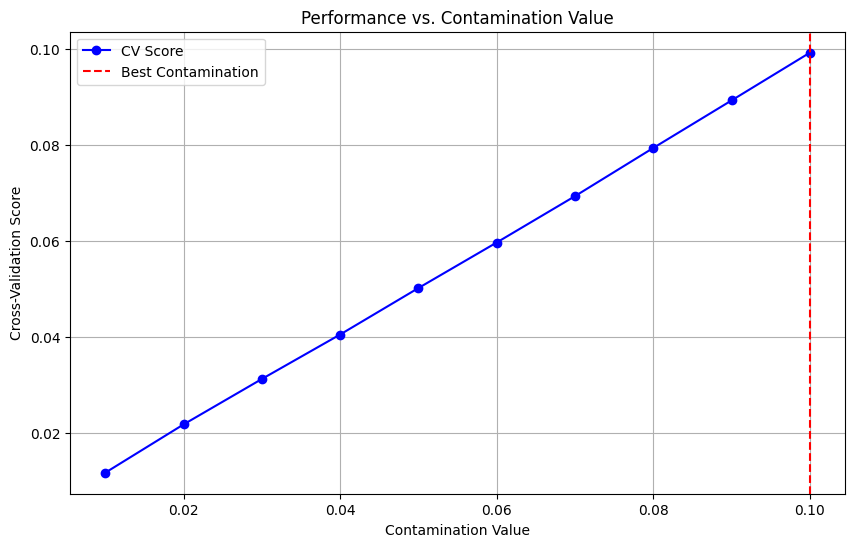

In [4]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(contamination_values, cv_scores, marker='o', linestyle='-', color='b')
plt.axvline(best_contamination, color='r', linestyle='--')
plt.xlabel('Contamination Value')
plt.ylabel('Cross-Validation Score')
plt.title('Performance vs. Contamination Value')
plt.legend(['CV Score', 'Best Contamination'])
plt.grid(True)
plt.show()


In [5]:

# Train the final model with the best contamination value on the entire scaled dataset
clf = IsolationForest(contamination=best_contamination, random_state=42)
clf.fit(X_scaled)
outlier_predictions = clf.predict(X_scaled)

# Create a new column to mark outliers in your original DataFrame
data['is_outlier'] = outlier_predictions

# Print the number of outliers detected
print("Number of Outliers Detected:", np.sum(outlier_predictions == -1))

Number of Outliers Detected: 141287


Checking the proportion of outliers by activities.

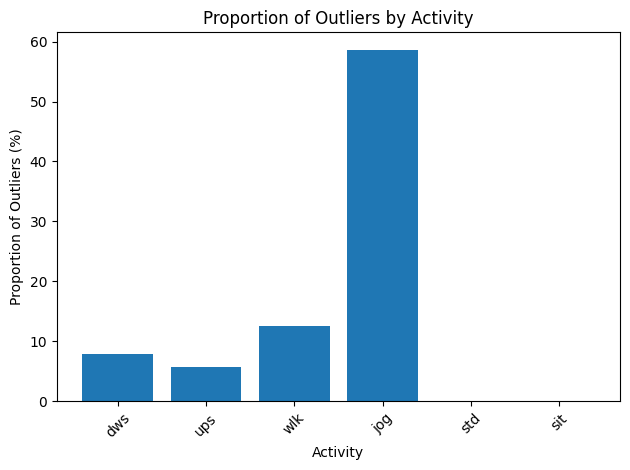

In [6]:
outlier_proportions = []
for activity in ACT_LABELS:
    total_samples = len(data[data['act'] == activity])
    outlier_samples = len(data[(data['act'] == activity) & (data['is_outlier'] == -1)])

    proportion = (outlier_samples / total_samples) * 100
    outlier_proportions.append(proportion)

# Plotting
plt.bar(ACT_LABELS, outlier_proportions)
plt.xlabel('Activity')
plt.ylabel('Proportion of Outliers (%)')
plt.title('Proportion of Outliers by Activity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


While most activities show a low to moderate proportion of outliers, the 'jog' activity stands out with a significantly higher percentage of outliers. This might indicate potential issues with data collection for the 'jog' activity, or it could reflect the inherent variability in jogging patterns among individuals. Further investigation would be required to understand the reasons behind such a high proportion of outliers in the 'jog' category.

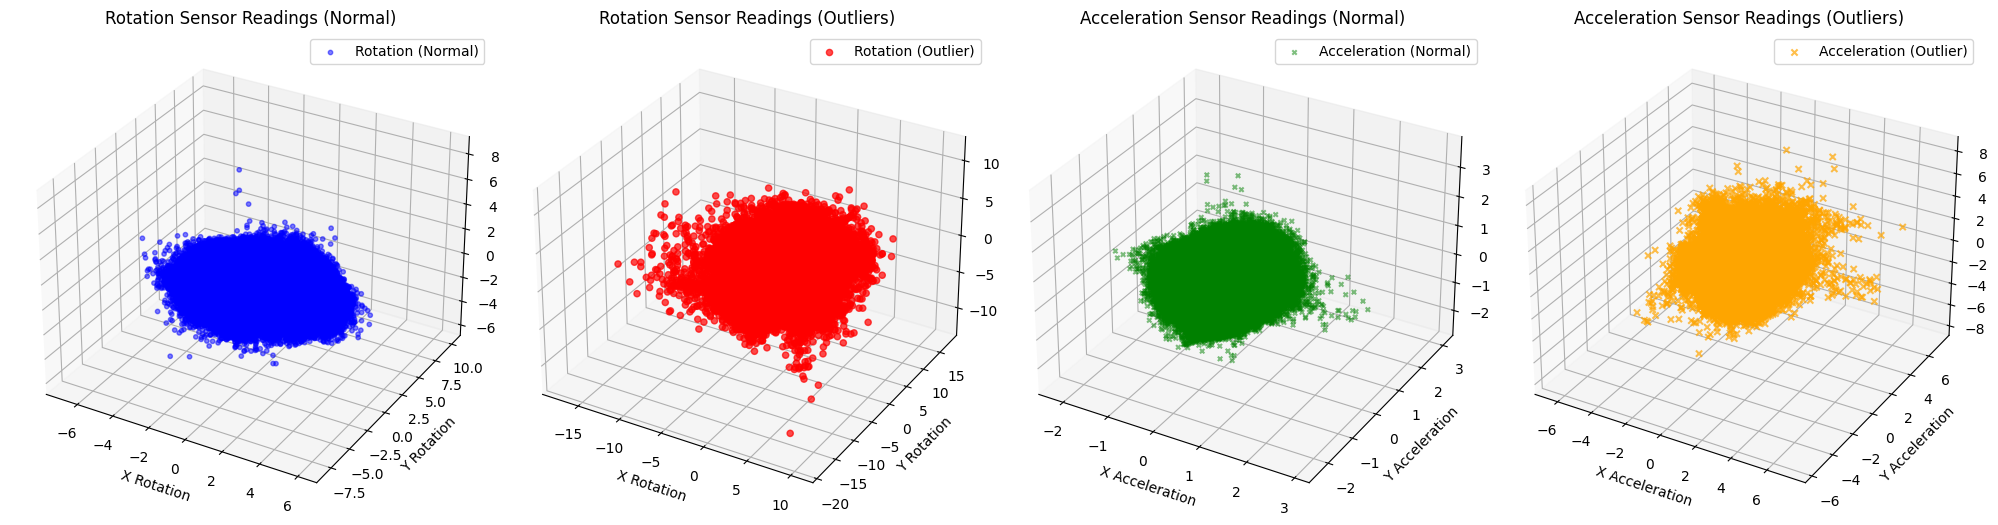

In [10]:
# Segregate the data into normal data and outliers based on the 'is_outlier' column
normal_data = data[data['is_outlier'] != -1]
anomalies = data[data['is_outlier'] == -1]

# Extract sensor readings for both normal data and outliers
def extract_sensor_readings(data, sensor_columns):
    return [data[column].values for column in sensor_columns]

normal_readings = extract_sensor_readings(normal_data, sensor_columns)
outlier_readings = extract_sensor_readings(anomalies, sensor_columns)

# Create the visualization
fig = plt.figure(figsize=(20, 8))

# Plotting for Rotation Sensor Readings
ax1 = fig.add_subplot(141, projection='3d')
ax1.set_title('Rotation Sensor Readings (Normal)')
ax1.set_xlabel('X Rotation')
ax1.set_ylabel('Y Rotation')
ax1.set_zlabel('Z Rotation')
ax1.scatter(*normal_readings[0:3], c='blue', label='Rotation (Normal)', s=10, alpha=0.5, marker='o')

ax2 = fig.add_subplot(142, projection='3d')
ax2.set_title('Rotation Sensor Readings (Outliers)')
ax2.set_xlabel('X Rotation')
ax2.set_ylabel('Y Rotation')
ax2.set_zlabel('Z Rotation')
ax2.scatter(*outlier_readings[0:3], c='red', label='Rotation (Outlier)', s=20, alpha=0.7, marker='o')

# Plotting for Acceleration Sensor Readings
ax3 = fig.add_subplot(143, projection='3d')
ax3.set_title('Acceleration Sensor Readings (Normal)')
ax3.set_xlabel('X Acceleration')
ax3.set_ylabel('Y Acceleration')
ax3.set_zlabel('Z Acceleration')
ax3.scatter(*normal_readings[3:], c='green', label='Acceleration (Normal)', s=10, alpha=0.5, marker='x')

ax4 = fig.add_subplot(144, projection='3d')
ax4.set_title('Acceleration Sensor Readings (Outliers)')
ax4.set_xlabel('X Acceleration')
ax4.set_ylabel('Y Acceleration')
ax4.set_zlabel('Z Acceleration')
ax4.scatter(*outlier_readings[3:], c='orange', label='Acceleration (Outlier)', s=20, alpha=0.7, marker='x')

# Setting Legends
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

plt.tight_layout()
plt.show()





1.   Distinct Clusters: The plots show clear clusters for both normal data and outliers. This clustering suggests that the outlier detection algorithm has identified distinct patterns in the data that differ from the norm.
2.   Spread and Distribution: The normal rotation data appears more condensed, whereas the outlier rotation data is more spread out.

3.   The outliers (especially for acceleration) are not just extreme values on the fringes but are spread throughout the range of the normal data. This indicates that the classification of outliers isn't just based on extreme values but other factors or combinations of factors.






In [14]:
data_outliers = data[data['is_outlier'] == -1]
# Save the outliers to a CSV file
data_outliers.to_csv('/content/drive/MyDrive/Fortifyedge/data/isolationForest/outliers_isf.csv', index=False)

# Filter the data to exclude outliers (where 'is_outlier' is not -1)
data_no_outliers = data[data['is_outlier']!= -1]

# Drop the 'is_outlier' column
data_no_outliers = data_no_outliers.drop(columns=['is_outlier'])

# Save the filtered data to a CSV file
data_no_outliers.to_csv('/content/drive/MyDrive/Fortifyedge/data/isolationForest/data_portion_isf.csv',index=False)

With the outliers removed, the remaining data is passed through the CNN model for human activity recognition.

Load the csv file for the CNN model.

In [12]:
PATH = '/content/drive/MyDrive/Fortifyedge/data/isolationForest/'
file_path =  PATH + 'data_portion_isf.csv'
isf_data = pd.read_csv(file_path)

X,y = transform_data(isf_data)

---> Data Standardization Started
Standardization Completed in: 614.2771947383881 seconds


In [13]:
X_train_isf, X_test_isf, y_train_isf, y_test_isf = train_test_split(X, y, test_size=0.2, random_state=None)

# Save X_test
np.save(PATH + 'X_test_isf.npy', X_test_isf)
# Save y_test
np.save(PATH + 'y_test_isf.npy', y_test_isf)

In [15]:
# Save X
np.save(PATH + 'Model_data/X.npy', X)

# Save y
np.save(PATH + 'Model_data/y.npy', y)

In [17]:
model_PATH = PATH + 'Model_data/isf_model.h5'
hist_PATH = PATH + 'Model_data/isf_history.npy'
history, X_train, X_test, y_train, y_train_pred, y_train_labels, y_test, y_test_pred, y_test_labels = optimized_train_eval_model(isf_data, model_PATH, hist_PATH, X,y, epochs = 10)

--->Training Model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 1, 128)        3712      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 1, 128)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 1, 128)        0         
                                                                 
 flatten (Flatten)           (None, 2944)              0         
                                                                 
 dense (Dense)               (None, 128)               376960    
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                     

In [20]:
# Function for plotting Accuracy, Loss and Learning curves
def plot_history(model_history):
    # Create a 1x2 grid of subplots
    plt.style.use("default")
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # Plot Accuracy Curve
    axes[0].plot(model_history.history['accuracy'], 'r-', label='Training Accuracy')
    axes[0].plot(model_history.history['val_accuracy'], 'b-', label='Validation Accuracy')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Accuracy Curve")
    axes[0].grid(True)
    axes[0].legend(loc="lower right")

    # Plot Loss Curve
    axes[1].plot(model_history.history['loss'], 'r-', label='Training Loss')
    axes[1].plot(model_history.history['val_loss'], 'b-', label='Validation Loss')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Loss Curve")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")


    plt.tight_layout()
    plt.show()


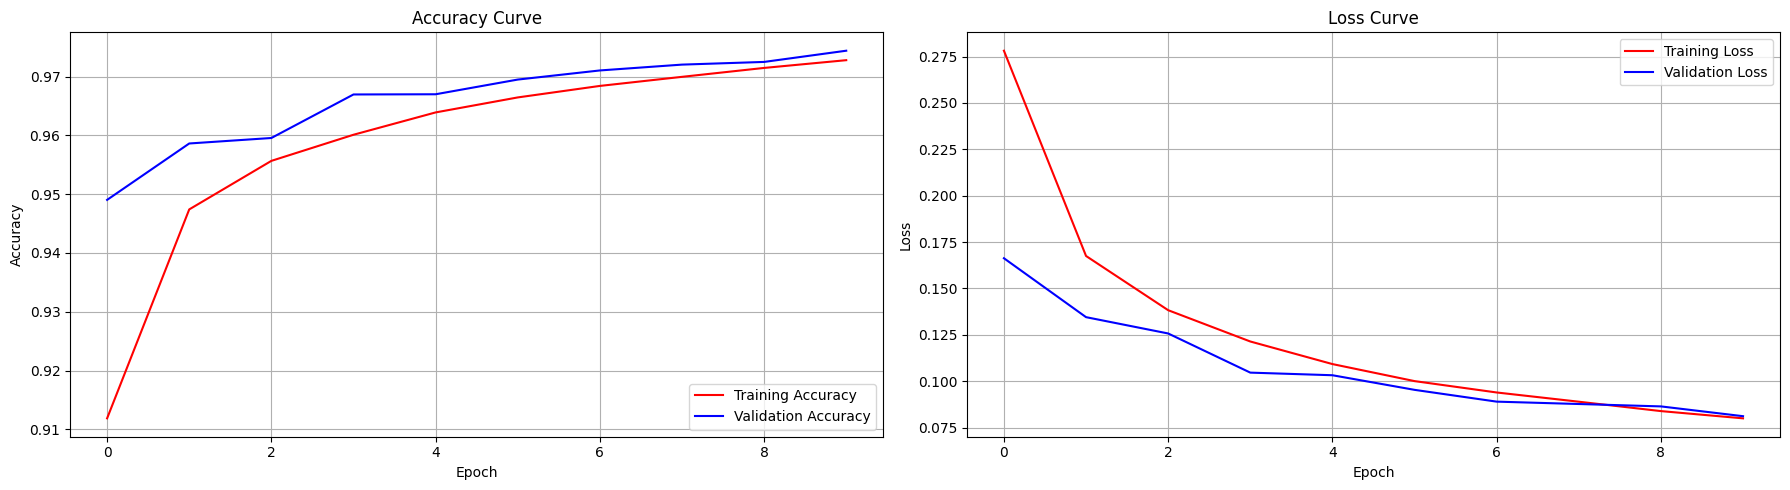

In [21]:
plot_history(history)

The model seems to be well-trained, given that there's no significant divergence between training and validation metrics. Overfitting typically manifests as training accuracy being much higher than validation accuracy, and training loss being much lower than validation loss. This isn't observed here, which is positive.
Underfitting would be indicated if both training and validation metrics performed poorly. Again, this isn't observed here.

Looking at other metrics:

In [22]:
class_report_train = classification_report(y_train_labels, y_train_pred)
print(class_report_train)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     98405
           1       0.99      0.95      0.97    119670
           2       0.98      0.99      0.99    245622
           3       0.99      0.99      0.99     48541
           4       0.98      0.99      0.99    244979
           5       0.99      0.99      0.99    271309

    accuracy                           0.98   1028526
   macro avg       0.98      0.98      0.98   1028526
weighted avg       0.98      0.98      0.98   1028526



In [23]:
class_report_test = classification_report(y_test_labels, y_test_pred)
print(class_report_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     24596
           1       0.99      0.95      0.97     29956
           2       0.98      0.99      0.99     61880
           3       0.98      0.98      0.98     11837
           4       0.98      0.99      0.98     61446
           5       0.99      0.99      0.99     67417

    accuracy                           0.98    257132
   macro avg       0.98      0.98      0.98    257132
weighted avg       0.98      0.98      0.98    257132



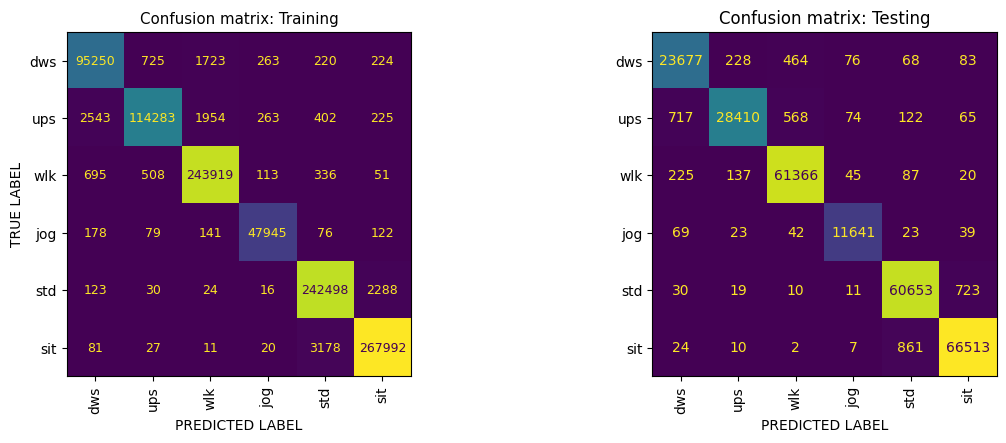

In [24]:
# Plot Confusion Matrix
plot_cm(y_train, y_train_pred, y_test, y_test_pred)

Performance comparison with base-line CNN model.

Load trained models

In [26]:
from keras.models import load_model
import os

# Define paths for the models
base_PATH = '/content/drive/My Drive/Fortifyedge/Baseline_model/'
isf_PATH = '/content/drive/My Drive/Fortifyedge/data/isolationForest/Model_data/'


# List of CNN models
cnn_ls = {'cnn_raw': [base_PATH, None],  # Initialize the model value as None
          'cnn_isf': [isf_PATH  + 'isf_model.h5', None]
          }

# Check if the CNN models are saved and load them
for model_name, model_info in cnn_ls.items():
    model_path = model_info[0]
    if os.path.exists(model_path):
        # Load the model
        model_info[1] = load_model(model_path)
    else:
        print(f"----> No model found for {model_name}.")

In [27]:
#ASSIGN THE CNN MODELS
cnn_baseline=cnn_ls['cnn_raw'][1]
cnn_isf=cnn_ls['cnn_isf'][1]

Load the test data

In [29]:
cnn_baseline_X_test = np.load(base_PATH + 'raw_X_test.npy')
cnn_baseline_y_test = np.load(base_PATH + 'raw_y_test.npy')
cnn_isf_X_test = np.load(isf_PATH + 'X.npy')
cnn_isf_y_test = np.load(isf_PATH +'y.npy')

Predict using the test sets

In [30]:
#predict using test sets
y_pred_raw_prob=pred(cnn_baseline,cnn_baseline_X_test)
y_pred_raw = np.argmax(y_pred_raw_prob, axis=1)

y_pred_isf_prob=pred(cnn_isf,cnn_isf_X_test)
y_pred_isf = np.argmax(y_pred_isf_prob, axis=1)

40177/40177 [==============================] - 111s 3ms/step


Load Model histories for comparison

In [31]:
baseline_history = np.load(base_PATH + 'raw_cnn_hist.npy', allow_pickle=True).item()
isf_history = np.load(isf_PATH + 'isf_history.npy', allow_pickle=True).item()

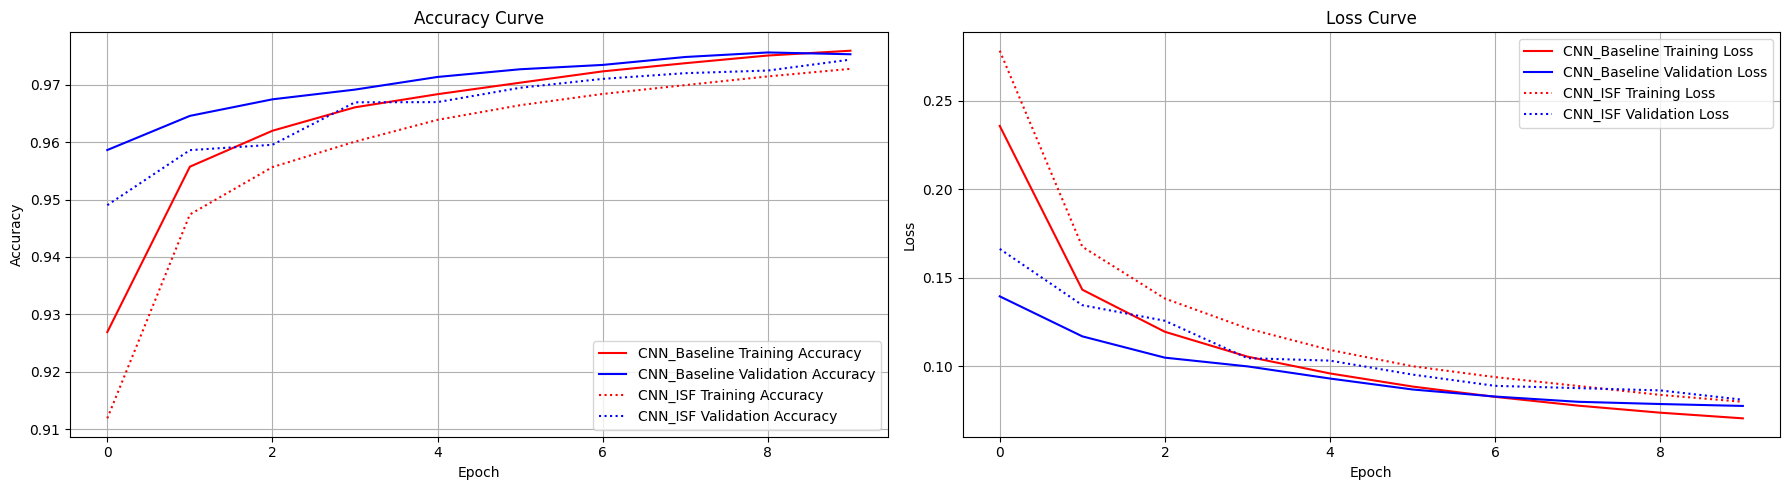

In [33]:
from helper_functions import plot_history
model_histories = [baseline_history,  isf_history]
model_labels = ["CNN_Baseline",  "CNN_ISF"]
linestyles = ['-', ':']  # Choose different linestyles for the models

plot_history(model_histories, model_labels, linestyles)

Training Accuracy: The CNN_ISF model (dotted blue curve) has a slightly lower training accuracy compared to the CNN_Baseline model (solid blue curve) throughout the epochs. This suggests that the CNN_ISF model may not be fitting the training data as well as the baseline.

Validation Accuracy: The CNN_ISF (dotted red curve) has consistently higher validation accuracy compared to the CNN_Baseline (solid red curve). This indicates that the CNN_ISF model generalizes better to new data, even if it has slightly lower training accuracy.

Training Loss: The CNN_ISF model (dotted blue curve on the loss graph) exhibits higher training loss than the CNN_Baseline (solid blue curve) over the epochs, which is consistent with its lower training accuracy.

Validation Loss: The CNN_ISF model (dotted red curve) shows a lower validation loss than the CNN_Baseline (solid red curve) over the epochs, which mirrors its superior validation accuracy.

Both models seem to be stabilizing in terms of accuracy and loss as the epochs progress, with no drastic changes observed in the later epochs.

In [39]:
def plot_cms(y_test_raw, y_test_pred_raw, y_test_quality, y_test_pred_quality):
  #  CONFUSION MATRIX
  #y_train = np.argmax(y_train, axis=-1)
  plt.style.use('bmh')
  y_test_raw = np.argmax(y_test_raw, axis=-1)
  y_test_quality = np.argmax(y_test_quality, axis=-1)

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
  plt.subplots_adjust(wspace=0.7)
  plt.rc('font', size=9)
  cm_raw =ConfusionMatrixDisplay.from_predictions(y_test_raw, y_test_pred_raw, ax=axs[0], display_labels=ACT_LABELS,normalize="true", values_format=".00%")
  axs[0].set_title("Confusion matrix: Raw Data")
  axs[0].set_xticklabels(ACT_LABELS, rotation=90)
  cm_raw.im_.colorbar.remove()
  axs[0].set_ylabel('TRUE LABEL')
  axs[0].set_xlabel('PREDICTED LABEL')

  plt.rc('font', size=10)
  cm_quality =ConfusionMatrixDisplay.from_predictions(y_test_quality, y_test_pred_quality, ax=axs[1], display_labels=ACT_LABELS,normalize="true", values_format=".00%")
  axs[1].set_title("Confusion matrix: Data portion (ISF)")
  axs[1].set_xticklabels(ACT_LABELS, rotation=90)
  cm_quality.im_.colorbar.remove()
  axs[1].set_ylabel('')
  axs[1].set_xlabel('PREDICTED LABEL')
  plt.show()

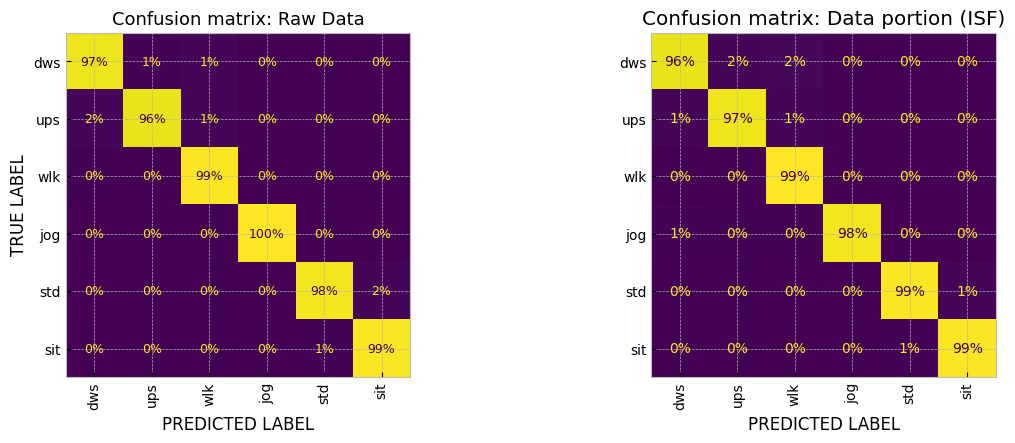

In [40]:
# PLOT CONFUSION MATRICES
plot_cms(cnn_baseline_y_test, y_pred_raw, cnn_isf_y_test, y_pred_isf)

Both datasets show high classification accuracy, There are small percentages of misclassifications (off-diagonal values), such as "dws" being misclassified as "ups" and vice versa. However, these misclassifications are relatively minimal.

Given that we loose 10% of raw data as outliers and get very similar accuracy to baseline model, that is an improvement.